In [7]:
# Import all modules you will use
import torchvision # pip install 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torch

In [8]:
# create a tensorbaord writer 
writer = SummaryWriter()


In [9]:
# Load in the dataset

pick = datasets.MNIST(root='./data', train=True, download=True)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())#This specifies that we want the test part of the MNIST dataset.
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

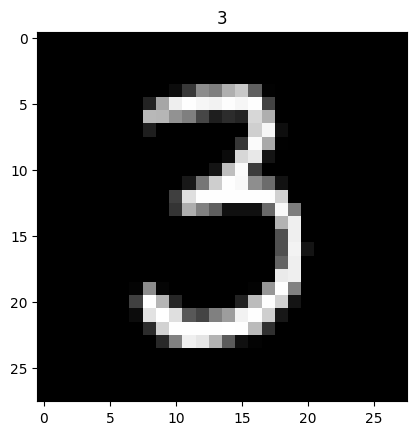

In [10]:
image, label = pick[50] 

plt.imshow(image, cmap="gray")
plt.title(f"{label}")
plt.show()

In [11]:
train_dataset[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
# Data cleaning or for NN - work on transforming the data
 #Takes list of Transformations & composes them into single trans(Applied in order). Converts images into tensors. Then normalizes tensor images.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 



In [13]:
# Create Data Loaders on the data to make it easy to feed data to the model in batches.


#make the data loaders

# Loads data in shuffled batches of 64 samples. Reduces overfitting.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Define a class to be the NN model (must have an __init__ and a forward function)
# init the nn class with an init function and a forward pass
class Net(nn.Module):                      # Defines a new class Net that inherits from nn.Module
    def __init__(self):  
        super(Net, self).__init__()  
        self.fc1 = nn.Linear(28*28, 512)   # Input: 28x28 image, Hidden layer: 512 neurons
        self.fc2 = nn.Linear(512, 10)     # Output: 10 classes (digits 0-9)
  
    def forward(self, x):                 # specifies how the input data flows through the network layers.
        x = x.view(-1, 28*28)             # Flatten the image (Removes some of the dimensions)
        x = F.relu(self.fc1(x))         # May not always be the same. ReLU is reliable. 
        x = self.fc2(x)                #   Passes the output from the previous layer to the second fully connected layer fc2
        return x                      #   Returns the final output of the network.

In [15]:
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
# Initilize the model
model = Net()


In [17]:
# Set the loss function
criterion = nn.CrossEntropyLoss() # BCEWithLogitsLoss could be used as well. 


In [18]:
# Set the optimizer function (Brett used "Adam") # could use SGD as well. 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_losses = []
train_accuracies = []
for epoch in range(10):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    epoch_loss /= len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 0: Loss: 0.2580, Accuracy: 92.70%
Epoch 1: Loss: 0.1014, Accuracy: 96.90%
Epoch 2: Loss: 0.0655, Accuracy: 98.02%
Epoch 3: Loss: 0.0473, Accuracy: 98.54%
Epoch 4: Loss: 0.0336, Accuracy: 99.00%
Epoch 5: Loss: 0.0245, Accuracy: 99.25%
Epoch 6: Loss: 0.0193, Accuracy: 99.40%
Epoch 7: Loss: 0.0154, Accuracy: 99.51%
Epoch 8: Loss: 0.0126, Accuracy: 99.62%
Epoch 9: Loss: 0.0095, Accuracy: 99.71%


In [20]:
## Define the training loop then and print the progress for the loop either every epoch or every 5 or 10 epochs. 
#for epoch in range(10): # where I left off @ me
#    for batch_idx, (data, target) in enumerate(train_loader):
#        optimizer.zero_grad()
#        output = model(data)
#        loss = criterion(output, target)
#        loss.backward()
#        optimizer.step()
#    #the song says "print out whats happening"
#    print(f'Epoch {epoch}: Loss: {loss.item():.4f}')

In [21]:
# Evaluate the model with the ".eval()" function
# Calulate the avergae loss and accuracy and print out the results
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # No gradients needed during evaluation
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Test Loss: 0.0013, Accuracy: 97.98%


In [22]:
epochs = range(1, 11)  # 1 to 10

plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

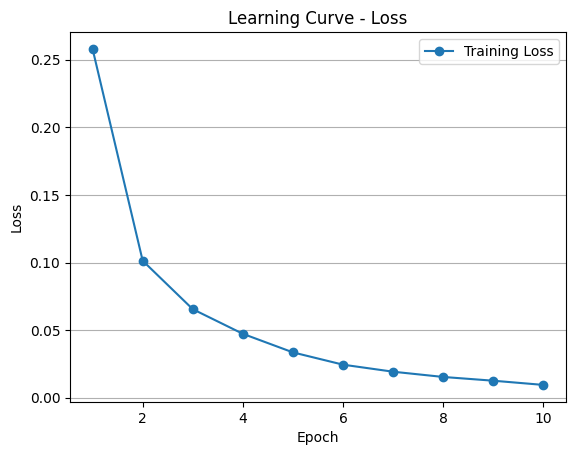

In [23]:
# Loss Chart
plt.subplot(1, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='y')

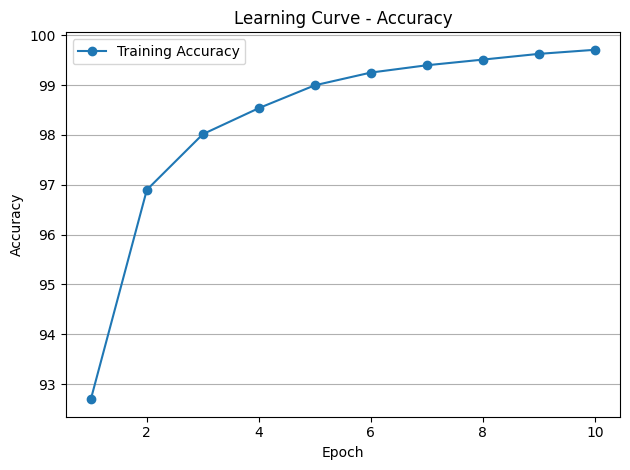

In [24]:
# Accuracy Chart
plt.subplot(1, 1, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()